# Lead Detection Inference Template

# Imports

In [ ]:
#!export CUDA_VISIBLE_DEVICES=1

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from tqdm import tqdm

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import time
import pandas as pd

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')

tf.__version__


'1.15.0'

## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

In [4]:
# Paths
root_dir = os.getcwd()
FROZEN_GRAPH_DIR='inference_graph/V-11-wichtig'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = os.path.join(root_dir, FROZEN_GRAPH_DIR, "frozen_inference_graph.pb")

# List of the strings that is used to add correct label for each box.
# PATH_TO_LABELS = os.path.join(root_dir, 'training_ocr_ssd_fpn_efficientnet', 'object-detection.pbtxt')
PATH_TO_LABELS = os.path.join('data', 'lead_detection_label_map.pbtxt')
print("Pb:\t{}\nLabelmap:\t{}".format(PATH_TO_FROZEN_GRAPH, PATH_TO_LABELS))

Pb:	D:\FZ_WS\JyNB\TF_Research_Api_LD_2_0\research\object_detection\inference_graph/V-11-wichtig\frozen_inference_graph.pb
Labelmap:	data\lead_detection_label_map.pbtxt


## Load a (frozen) Tensorflow model into memory.

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    print('Graph import successful')

Graph import successful


## Loading label map
Label maps map indices to category names

In [6]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
print(category_index)

{1: {'id': 1, 'name': 'BODY'}, 2: {'id': 2, 'name': 'PIN'}}


## Helper code

In [14]:
def load_image_into_numpy_array(image, grayscale = False):
  (im_width, im_height) = image.size
  if grayscale:
      return np.repeat(np.asarray(image)[:, :, np.newaxis], 3, axis = 2)
  else:
      return np.array(image.getdata()).reshape(
          (im_height, im_width, 3)).astype(np.uint8)

In [9]:
def createDirirectory(path):
    if not os.path.isdir(path):
        os.makedirs(path)
        print ("Creating {}".format(path))
    return path

# Detection

In [16]:
import glob

# Paths
PATH_TO_IMAGES_DIR = "images"
PATH_TO_TEST_IMAGES_DIR = os.path.join(PATH_TO_IMAGES_DIR, "test")
PATH_TO_OUT_IMG_DIR = createDirirectory("debug/images_out-V-11-wichtig")
PATH_TO_OUT_TEST_IMAGES_DIR = os.path.join(PATH_TO_OUT_IMG_DIR, "test")

# Image Path
TEST_IMAGE_PATHS = [f for f in glob.glob(PATH_TO_TEST_IMAGES_DIR + "/*.jpg", recursive=True)]

if (len(TEST_IMAGE_PATHS) >0) :
    createDirirectory(PATH_TO_OUT_IMG_DIR)
    createDirirectory(PATH_TO_OUT_TEST_IMAGES_DIR)

# Size, in inches, of the output images.
IMAGE_SIZE = (20, 10)
print("Count TEST_IMAGE_PATHS:\t{}".format(len(TEST_IMAGE_PATHS)))
print("DONE!")

Creating debug/images_out-V-11-wichtig\test
Count TEST_IMAGE_PATHS:	24
DONE!


In [17]:
def run_inference_for_images(images_path, graph):
    with graph.as_default():
        #config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True,visible_device_list='1'))
        config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
        with tf.Session(config = config) as sess:
            output_dict_array = []
            
            for image_path in tqdm(images_path):
                
                image = Image.open(image_path)
          
                # Get handles to input and output tensors
                ops = tf.get_default_graph().get_operations()
                all_tensor_names = {output.name for op in ops for output in op.outputs}
                tensor_dict = {}
                for key in [
                    'num_detections', 'detection_boxes', 'detection_scores',
                    'detection_classes', 'detection_masks'
                ]:
                    tensor_name = key + ':0'
                    if tensor_name in all_tensor_names:
                        tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                            tensor_name)
                if 'detection_masks' in tensor_dict:
                    detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                    detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                    # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                    real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                    detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                    detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                        detection_masks, detection_boxes, image.shape[0], image.shape[1])
                    detection_masks_reframed = tf.cast(
                        tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                    # Follow the convention by adding back the batch dimension
                    tensor_dict['detection_masks'] = tf.expand_dims(
                        detection_masks_reframed, 0)
                image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
                
                # Run inference
                output_dict = sess.run(tensor_dict,
                                       feed_dict={image_tensor: np.expand_dims(image, 0)})

                # all outputs are float32 numpy arrays, so convert types as appropriate
                output_dict['num_detections'] = int(output_dict['num_detections'][0])
                output_dict['detection_classes'] = output_dict[
                    'detection_classes'][0].astype(np.uint8)
                output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
                output_dict['detection_scores'] = output_dict['detection_scores'][0]
                if 'detection_masks' in output_dict:
                    output_dict['detection_masks'] = output_dict['detection_masks'][0]

                output_dict_array.append(output_dict)
  
            
    return output_dict_array


In [18]:
# Predition
images = []
print("Running inference sess...")
start = time.time()
output_dict_array = run_inference_for_images(TEST_IMAGE_PATHS, detection_graph)


  0%|                                                                                                                                                                                                                           | 0/24 [00:00<?, ?it/s]

Running inference sess...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:08<00:00,  2.97it/s]


In [19]:
import pandas as pd
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# # Predition
# images = []
# print("Running inference sess...")
# start = time.time()
# output_dict_array = run_inference_for_images(TEST_IMAGE_PATHS, detection_graph)

# Visualize and Record Prediction Result
print("Running Visualize and Record Prediction Result...")
for index, output_dict in enumerate(tqdm(output_dict_array)):
    # Load Image
    image_path = TEST_IMAGE_PATHS[index]
    image = Image.open(image_path)
    
    #image_np = load_image_into_numpy_array(image, grayscale=True)
    image_np = load_image_into_numpy_array(image)
    
    if not (os.path.isdir(PATH_TO_OUT_TEST_IMAGES_DIR)):
        os.makedirs(PATH_TO_OUT_TEST_IMAGES_DIR)
    out_image_path = os.path.join( PATH_TO_OUT_TEST_IMAGES_DIR , os.path.basename(image_path))
    out_text_path = out_image_path.replace('.jpg','.txt')
        
    #     if (output_dict['num_detections']<100):
    #         print(".")
    #         continue
        
    # Output Images
    vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          output_dict['detection_boxes'],
          output_dict['detection_classes'],
          output_dict['detection_scores'],
          category_index,
          instance_masks=output_dict.get('detection_masks'),
          use_normalized_coordinates=True,
          line_thickness=3,
          skip_scores=False,
          skip_labels=True,
        max_boxes_to_draw=256,
        min_score_thresh=.0)
    
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    plt.savefig(out_image_path)

    
    # Output Text
    boxes = output_dict['detection_boxes']
    # get all boxes from an array
    max_boxes_to_draw = boxes.shape[0]
    # get scores to get a threshold
    scores = output_dict['detection_scores']
    # this is set as a default but feel free to adjust it to your needs
    width, height = image.size

    detected_img_list = []
    detected_class_list = []
    detected_score_list = []
    detected_x_min = []
    detected_y_min = []
    detected_x_max = []
    detected_y_max = []

    min_score_thresh=.5
    # iterate over all objects found
    for i in range(min(max_boxes_to_draw, boxes.shape[0])):
      if scores is None or scores[i] > min_score_thresh:
          # boxes[i] is the box which will be drawn
          class_name = category_index[output_dict['detection_classes'][i]]['name']
          confidence_score = scores[i]
          y_min = boxes[i][0] * height
          x_min = boxes[i][1] * width
          y_max = boxes[i][2] * height
          x_max = boxes[i][3] * width

          detected_img_list.append(os.path.basename(image_path))
          detected_class_list.append(class_name)
          detected_score_list.append(confidence_score)
          detected_x_min.append(int(x_min))
          detected_y_min.append(int(y_min))
          detected_x_max.append(int(x_max))
          detected_y_max.append(int(y_max))
        
    myPrediction = pd.DataFrame({
        'xmin': detected_x_min,
        'ymin': detected_y_min,
        'xmax': detected_x_max,
        'ymax': detected_y_max,
        'class': detected_class_list,
        'scores': detected_score_list
    })
    myPrediction.to_csv(out_text_path,encoding='utf-8', header=None, index=False, sep=",")
    

print('Done')
end = time.time()
total_time = end - start
print(end - start)

  0%|                                                                                                                                                                                                                           | 0/24 [00:00<?, ?it/s]

Running Visualize and Record Prediction Result...


C:\Users\V510\Anaconda3\envs\TF_15_Py36\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:31<00:00,  1.30s/it]

Done
39.391326665878296


### Detection distribution

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Library Complete")

Library Complete


Detection distribution


4     767
3     692
1     448
2     284
7     246
5     110
15     86
6      85
8      25
23      9
58      8
25      8
9       7
26      6
67      6
56      5
24      5
54      4
53      4
55      4
68      4
64      3
57      3
61      3
50      2
16      2
22      2
71      2
27      2
51      2
59      2
63      2
65      2
70      2
60      1
52      1
62      1
46      1
66      1
49      1
Name: detection_per_img, dtype: int64

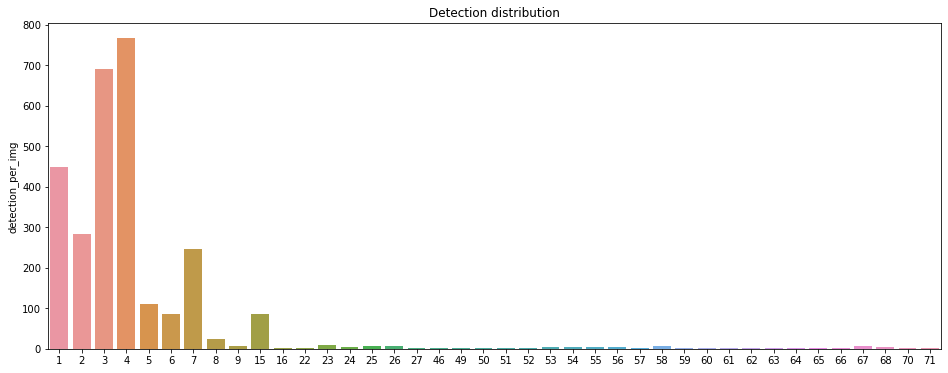

In [21]:
detection_per_img=[]
for e in output_dict_array:
    detection_per_img.append(e['num_detections'])

df_detection_per_img = pd.DataFrame.from_dict({'detection_per_img': detection_per_img})
plt.figure(figsize=(16,6))
plt.title("Detection distribution")
sns.barplot( x=df_detection_per_img['detection_per_img'].value_counts().index, y=df_detection_per_img['detection_per_img'].value_counts())
print("Detection distribution")
df_detection_per_img['detection_per_img'].value_counts()